In [36]:
import torch
import numpy as np
from models.training import easyTrainer, weights_to_dataset
from models.nODE import nODE, make_nODE_from_parameters
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch.utils.data import Dataset
from torchdiffeq import odeint
from data_creation import create_dataset

In [2]:
adj_list = []
adj_list.append(np.array([[0.,0.],[0.,0.]]))
adj_list.append(np.array([[0,1.],[0,0]]))
adj_list.append(np.array([[0,-1.],[0,0]]))
adj_list.append(np.array([[0,1.],[1.,0]]))
adj_list.append(np.array([[0,1.],[-1.,0]]))
adj_list.append(np.array([[0,-1.],[-1.,0]]))

In [37]:
x,x_noise,y,param = create_dataset(2,1,100)

NameError: name 'dim' is not defined

In [5]:
class param_classifier(torch.nn.Module):
    def __init__(self,input_size,ode_dim,layers_size=[10,10,10,10]):
        super().__init__()

        self.layers_size = layers_size
        self.input_size = input_size
        self.output_size = 2*ode_dim**2+3*ode_dim
        print(self.output_size)
        self.ode_dim = ode_dim

        self.num_layers = len(layers_size)

        # initialise linear layers for classification block
        self.linears = torch.nn.ModuleList([torch.nn.Linear(input_size, layers_size[0])])
        self.linears.extend([torch.nn.Linear(layers_size[i-1], layers_size[i]) for i in range(1, self.num_layers-1)])
        self.linears.append(torch.nn.Linear(layers_size[len(layers_size)-1], self.output_size))

    # forward pass of NN (both classifier and neural ODE)
    def forward(self, data):

        x = data
        for i in range(0,len(self.layers_size)-2):
            x = self.linears[i](x)
            x = F.relu(x)
        
        # here x denote the estimated parameters for the ODE
        x = self.linears[len(self.layers_size)-1](x)

        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

classifier = param_classifier(4,2).to(device)
ode_dim = 2
integration_time = 1
node = nODE(ode_dim, architecture='both', time_interval=[0, integration_time]).to(device)
loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)

for epoch in range(100):
    
    for i in range(0,len(x_train)):
        x = x_train
        y = y_train
        # set loss to zero
        loss = 0

        y_train = torch.tensor(np.random.rand(1,6))[0].to(device)

        # get necessary inputs from data
        classifier_inp = x_train[0].to(device)

        # get u_0, u_T from data
        u0 = classifier_inp[:2]
        ut = y_train[:2]

        # get true adjacency from data
        A = y_train[2:]

        # estimate parameters using classifier network
        p = classifier(classifier_inp)

        print(p)

        # define ODE with found weights
        node.set_vec_weights(p)

        # integrate ODE
        ut_hat = node.forward(u0)

        # estimate adjacency matrix from output of classifier network
        Ahat = node.adjacency_matrix()

        # add to loss: error between found adjacency and true adjacency
        loss = loss + loss_fn(A.flatten().float(),Ahat.flatten().float())

        # add to loss: error between found solution at time t and true solution 
        loss = loss + loss_fn(ut_hat.float(),ut.float())

        # print('Epoch ' + str(epoch))
        # print(loss)

        # backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(list(classifier.parameters())[0].grad)

14
tensor([ 0.6977, -0.2418,  0.0309,  0.2882, -1.0911,  0.8691,  0.0275, -0.0777,
        -0.2218, -0.0761, -0.5521, -0.2818, -0.2083, -0.4940], device='cuda:0',
       grad_fn=<AddBackward0>)
None
tensor([ 0.6977, -0.2418,  0.0309,  0.2882, -1.0911,  0.8691,  0.0275, -0.0777,
        -0.2218, -0.0761, -0.5521, -0.2818, -0.2083, -0.4940], device='cuda:0',
       grad_fn=<AddBackward0>)
None
tensor([ 0.6977, -0.2418,  0.0309,  0.2882, -1.0911,  0.8691,  0.0275, -0.0777,
        -0.2218, -0.0761, -0.5521, -0.2818, -0.2083, -0.4940], device='cuda:0',
       grad_fn=<AddBackward0>)
None
tensor([ 0.6977, -0.2418,  0.0309,  0.2882, -1.0911,  0.8691,  0.0275, -0.0777,
        -0.2218, -0.0761, -0.5521, -0.2818, -0.2083, -0.4940], device='cuda:0',
       grad_fn=<AddBackward0>)
None
tensor([ 0.6977, -0.2418,  0.0309,  0.2882, -1.0911,  0.8691,  0.0275, -0.0777,
        -0.2218, -0.0761, -0.5521, -0.2818, -0.2083, -0.4940], device='cuda:0',
       grad_fn=<AddBackward0>)
None
tensor([ 0.6977, 

KeyboardInterrupt: 

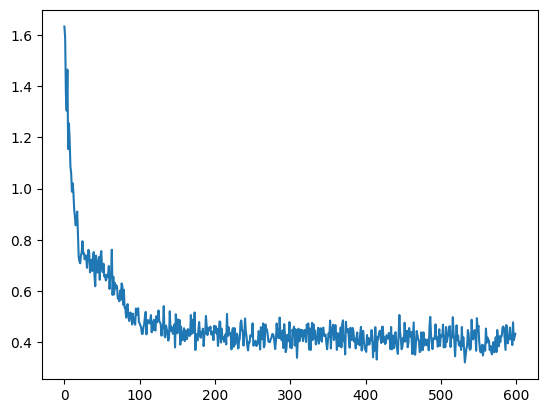

In [ ]:
import matplotlib
loss_vec = np.zeros(len(testloss))
for k in range(0,len(testloss)):
    loss_vec[k] = testloss[k].cpu().detach().numpy()

matplotlib.pyplot.plot(range(len(testloss)),loss_vec)

In [ ]:
correct = 0
total = 0
for data_point in TestData:
    data = data_point[0].to(device)
    out = model(data)

    guess = out.cpu() > 0.7
    print(guess)
    print(data_point[1])
    if sum(abs(guess.float()-data_point[1])) < 0.001:
        correct += 1
    total += 1

print(correct/total)

tensor([ True, False])
tensor([0., 0.])
tensor([False, False])
tensor([0., 0.])
tensor([ True, False])
tensor([0., 0.])
tensor([False, False])
tensor([0., 0.])
tensor([False, False])
tensor([0., 0.])
tensor([ True, False])
tensor([0., 0.])
tensor([False, False])
tensor([0., 0.])
tensor([False, False])
tensor([0., 0.])
tensor([ True, False])
tensor([0., 0.])
tensor([False, False])
tensor([0., 0.])
tensor([ True, False])
tensor([0., 0.])
tensor([ True, False])
tensor([0., 0.])
tensor([False, False])
tensor([0., 0.])
tensor([ True, False])
tensor([0., 0.])
tensor([False, False])
tensor([0., 0.])
tensor([ True, False])
tensor([0., 0.])
tensor([False, False])
tensor([0., 0.])
tensor([False, False])
tensor([0., 0.])
tensor([ True, False])
tensor([0., 0.])
tensor([False, False])
tensor([0., 0.])
tensor([ True, False])
tensor([1., 0.])
tensor([ True, False])
tensor([1., 0.])
tensor([False, False])
tensor([1., 0.])
tensor([ True, False])
tensor([1., 0.])
tensor([False, False])
tensor([1., 0.])
